In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Question A : non-parametric VaR

## a) Computation of the non-parametric VaR.

Importation of the Natixis Stock.

In [31]:
df = pd.read_csv("data/natixis.csv", sep = ";", decimal = ",")

In [32]:
df.head()

,date,price
0,02/01/2015,5.621
1,05/01/2015,5.424
2,06/01/2015,5.329
3,07/01/2015,5.224
4,08/01/2015,5.453


In [33]:
df.dtypes

date      object
price    float64
dtype: object

We need to use date as an index. Let's convert them to DateTime.

In [34]:
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df.head()

,date,price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453


Let's compute the returns :

In [35]:
df['price_return'] = df['price'].pct_change()
df.head()

,date,price,price_return
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836


The first return is not defined since we don't know the previous value. We just delete it and extract year 2015 and 2016.

In [36]:
df_1516 = df[df["date"].dt.year < 2017].copy()
df_1516.dropna(inplace = True)
df_1516.head()

,date,price,price_return
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
5,2015-01-09,5.340,-0.020723


Non-parametric VaR is defined using the non-parametric Kernel distribution :
$$
\hat{F}_n(x) := \frac{1}{n} \sum_{i = 1}^n \Kappa \left(\frac{x-X_i}{h}\right)
$$
Where :
- $n$ : number of observations.
- $h$ : bandwith, smoothing parameter. 

In this example, we are going to use the logistic Kernel :
$$
\Kappa(x) := \frac{1}{1 + e^{-x}}, \quad K(x) := \frac{e^{-x}}{(1 + e^{-x})^2}.
$$

We define the Kernel function and then the estimator of $F$ :

In [37]:
K = lambda x: 1/(1 + np.exp(-x)) # Logistic distribution.

def F_Kernel_Esti(data, h, x):
    n = len(data)
    return 1/n * sum([K((x - data[i])/h) for i in range(n)])

# Vectorized version of the function : Makes it quicker, the argument x is a vector.

def F_Kernel_Esti_Vec(data, h, X):
    n = len(data)
    return np.array([np.sum(1 / (1 + np.exp(-(x - data) / h))) / n for x in X])

The choice of bandwith is paramount in Kernel estimation. For the Gaussian Kernel, Silverman's rule of thumb gives the optimal parameter : $\hat{h}_{opt} = 1,06 \hat{\sigma}n^{1/5}$. This doesn't apply in our case. To chose the right bandwith, we will use a graph.

C:\Users\robin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


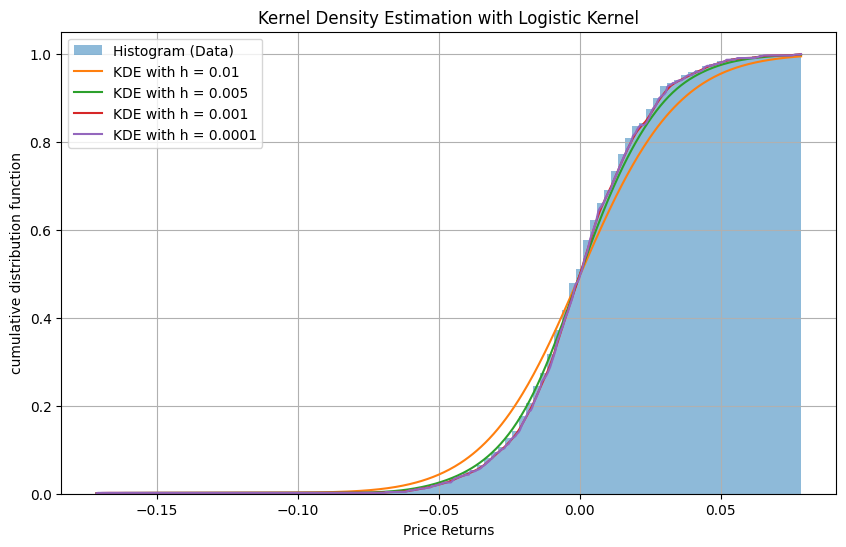

In [38]:
data = df_1516['price_return']

x_values = np.linspace(data.min(), data.max(), 512) # Values for the x-axis, starting from the minimum value of the data to the maximum value.

H = [0.01, 0.005, 0.001, 0.0001] # Bandwidths.

plt.figure(figsize = (10, 6))
plt.hist(data, bins = 100, density = True, alpha = 0.5, label = 'Histogram (Data)', cumulative = True) # Plotting the cdf of the data.
for h in H:
    kde = F_Kernel_Esti_Vec(data, h, x_values)
    plt.plot(x_values, kde, label = f'KDE with h = {h}')
    
plt.title('Kernel Density Estimation with Logistic Kernel')
plt.xlabel('Price Returns')
plt.ylabel('cumulative distribution function')
plt.legend()
plt.grid()
plt.show()

As we can see, the KDE with parameter $h = 0.01$ smooths the distribution too hard. On the other hand, the one with parameter $h = 0.0001$ over-learns the distribution. We can discard those values.

Next, we want to focus on the lower tail of the distribution. Since these are price returns, the VaR will be on the lower end of the graph. If we zoom in on that part of the graph :

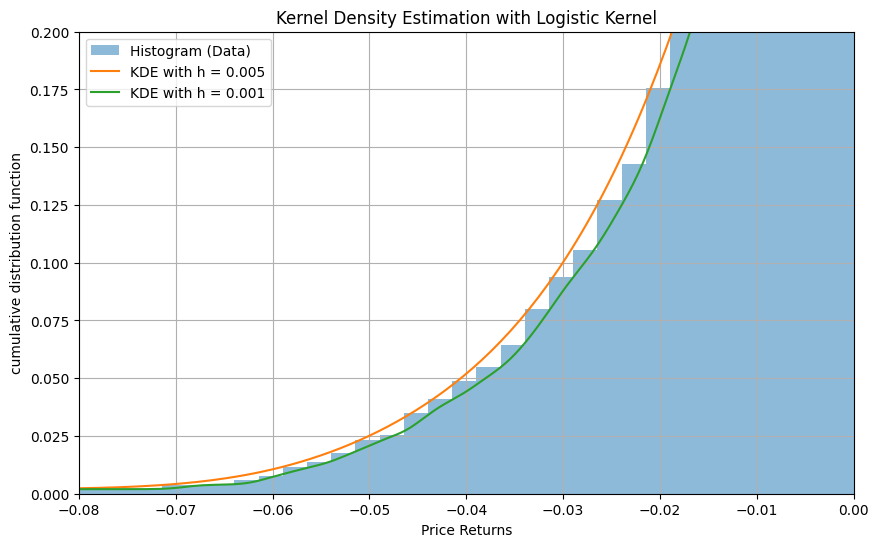

In [39]:
H = [0.005, 0.001]
plt.figure(figsize = (10, 6))
plt.hist(data, bins = 100, density = True, alpha = 0.5, label = 'Histogram (Data)', cumulative = True) # Plotting the cdf of the data.
for h in H:
    kde = F_Kernel_Esti_Vec(data, h, x_values)
    plt.plot(x_values, kde, label = f'KDE with h = {h}')
    
plt.title('Kernel Density Estimation with Logistic Kernel')
plt.xlabel('Price Returns')
plt.ylabel('cumulative distribution function')
plt.xlim(-0.08, 0)
plt.ylim(0, 0.2)
plt.legend()
plt.grid()
plt.show()

Both of those parameters seem to estimate the distribution well. Since we are talking about risk, we better overestimate it. Hence we chose :
$$
h = 0.005
$$

In [40]:
h = 0.005

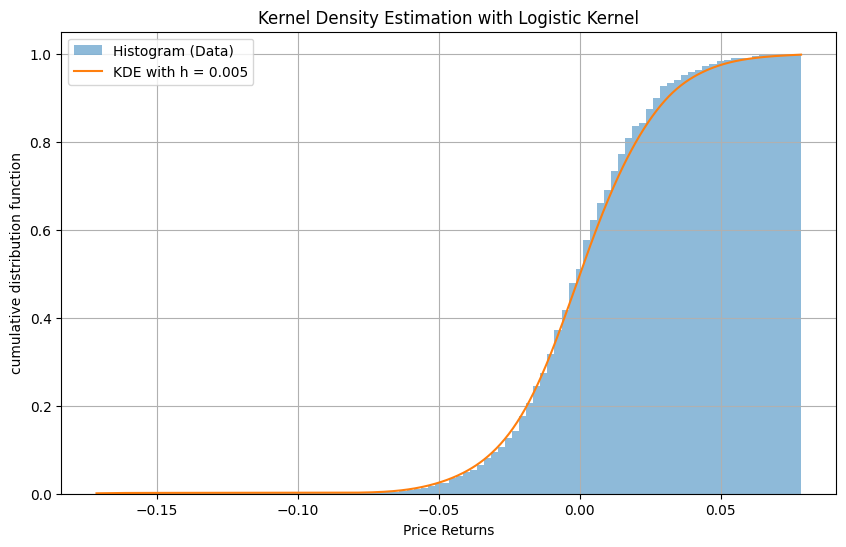

In [41]:
plt.figure(figsize = (10, 6))
plt.hist(data, bins = 100, density = True, alpha = 0.5, label = 'Histogram (Data)', cumulative = True) # Plotting the cdf of the data.
kde = F_Kernel_Esti_Vec(data, h, x_values)
plt.plot(x_values, kde, label = f'KDE with h = {h}') 
plt.title('Kernel Density Estimation with Logistic Kernel')
plt.xlabel('Price Returns')
plt.ylabel('cumulative distribution function')
plt.legend()
plt.grid()
plt.show()

ps : We do not really care about the understimation of the upper tail of the distribution. We know that prices tend to have fatter tails and since the logistic distribution is symetric, we cannot capture that characteristic.

Then, we proceed with the computation of the VaR based on the estimation we just did. To do so, we will simply go through the values we computed and stop whenever we hit the threshold.

In [42]:
def Compute_VaR(data, alpha, h, grid_size = 500):
    x_values = np.linspace(data.min(), data.max(), grid_size)
    for x in x_values:
        if F_Kernel_Esti(data, h, x) >= 1 - alpha:
            return x
    return None  # No value found.

We check that the program works with an easily identifiable value for alpha = 0.9 :

In [43]:
Compute_VaR(np.array(data), 0.9, h)

np.float64(-0.029679732723183277)

This is what we expected according to the second to last graph.

Then, to estimate whatever VaR, for high values of $\alpha$, 

In [44]:
alpha = 0.95

In [45]:
Compute_VaR(np.array(data), alpha, h)

np.float64(-0.040190534624647445)

For example, the VaR at $95\%$ of the Natixis stock is a negative return of $4 \%$.

## b) Backtesting of the non-parametric VaR.

We proceed with the backtesting of the VaR, we need to check that 95% of the returns, at least, are above $-4\%$ on a different time period.

In [46]:
df_backtest = df[df["date"].dt.year > 2016]
df_backtest.head()

,date,price,price_return
513,2017-01-02,5.400,0.007463
514,2017-01-03,5.620,0.040741
515,2017-01-04,5.641,0.003737
516,2017-01-05,5.595,-0.008155
517,2017-01-06,5.563,-0.005719


In [47]:
def validation(data, alpha):
    VaR = Compute_VaR(np.array(data), alpha, h)
    Count = 0
    for x in data:
        if x < VaR: # We trust our estimations of the distribution better in the lower tail.
            Count += 1
    return 1 - Count / len(data) # Proportion of values above the VaR.

In [48]:
validation(df_backtest["price_return"], alpha)

0.9647058823529412

Our computation of the non-parametric VaR is validated.

# Question B : European Option Pricing.

The data is between 2015 and 2018, so we want the whole dataframe.

In [49]:
df.head() # We check that we have the untuched data.

,date,price,price_return
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836


The arithmetic variation of price is defined as:
$$
\Delta S_t := S_t - S_{t - 1}.
$$

We assume that :
$$
\Delta S_t \sim \mathcal{N}(\mu, \sigma^2),
$$

We compute the log returns :

In [50]:
df_B = df.copy()
df_B['arithmetic_variations'] = df_B['price'] - df_B['price'].shift(1)
df_B = df_B[1:].copy()  # Remove the first row with NaN
df_B.head()

,date,price,price_return,arithmetic_variations
1,2015-01-05,5.424,-0.035047,-0.197
2,2015-01-06,5.329,-0.017515,-0.095
3,2015-01-07,5.224,-0.019704,-0.105
4,2015-01-08,5.453,0.043836,0.229
5,2015-01-09,5.340,-0.020723,-0.113


Exponential weighting,
$$
w_t = \lambda^{T - t},
$$
with $\lambda \in (0,1)$ : exponential weighting parameter for the volatility.

Foe example, we chose :

In [51]:
lambda_ = 0.88

Bollen, Bernard. (2015). What should the value of lambda be in the exponentially weighted moving average volatility model?. Applied Economics. 47. 853-860. 10.1080/00036846.2014.982853. 

We apply the weights :

In [52]:
weights = np.array([lambda_**i for i in range(len(df_B))][::-1]) # Weights for the exponentially weighted moving average, in reverse order.

df_B['Weighted_arithmetic_variations'] = df_B['arithmetic_variations'] * weights / sum(weights)

df_B.head()

,date,price,price_return,arithmetic_variations,Weighted_arithmetic_variations
1,2015-01-05,5.424,-0.035047,-0.197,-4.902931e-59
2,2015-01-06,5.329,-0.017515,-0.095,-2.686770e-59
3,2015-01-07,5.224,-0.019704,-0.105,-3.374531e-59
4,2015-01-08,5.453,0.043836,0.229,8.363287e-59
5,2015-01-09,5.340,-0.020723,-0.113,-4.689616e-59


Then, the weighted parameters are given by :
$$
\hat{\mu}_w = \frac{\sum_{t} w_t \Delta S_t}{\sum_{t} w_t}, \quad \hat{\sigma}^2_w = \frac{\sum_{t} w_t \left(\Delta S_t - \hat{\mu}_w \right)^2}{\sum_{t} w_t}
$$

In [53]:
mu_w = np.sum(weights * df_B['arithmetic_variations']) / np.sum(weights)
sigma_w = np.sqrt(np.sum(weights * (df_B['arithmetic_variations'] - mu_w) ** 2) / np.sum(weights))
print(mu_w, sigma_w)

-0.02487813407099429 0.10928976875063803


Let $S_T$ be the price at the last date of 2018 (ie the last entry in the dataframe), the price at the next time is $S_{T + 1}$ and is given by :
$$
\Delta S_{T + 1} = \hat{\mu}_w + \hat{\sigma}_w \cdot B_{T + 1}, \quad B_{T + 1} \sim \mathcal{N}(0, 1),
$$
with :
$$
S_{T + 1} = S_T + \Delta S_{T + 1}.
$$

We proceed with the simulation :

In [54]:
N = 10000  # Number of simulations
S_T = df['price'].iloc[-1]  # Last price of 2018
B_T1 = np.random.normal(0, 1, N)  # Generate N standard normal samples

# Simulated prices
simulated_prices = S_T + mu_w + sigma_w * B_T1

We chose $N = 10000$ as we are doing Monte Carlo simulations so it converges at a rate $n^{-1/2}$ and we do not want the computations to be too expansive either.

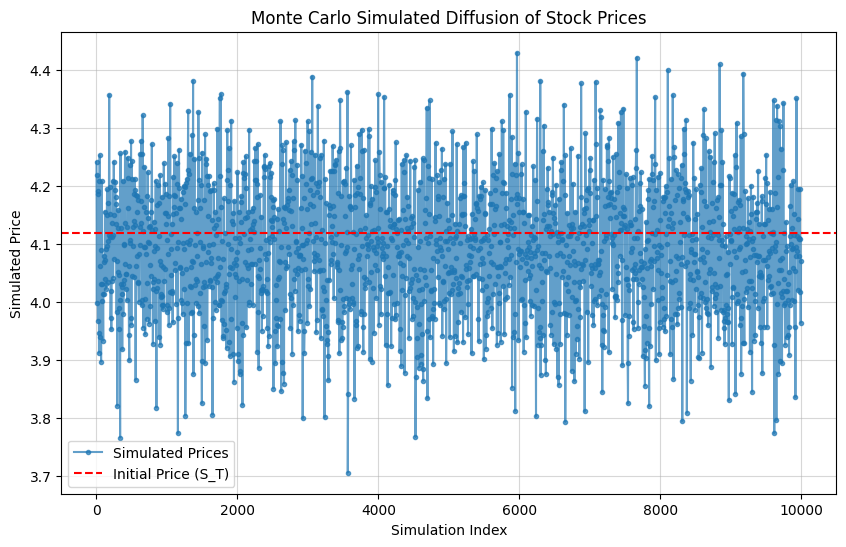

In [55]:
plt.figure(figsize = (10, 6))
x_indices = range(1, len(simulated_prices) + 1)
plt.plot(x_indices[::5], simulated_prices[::5], marker = 'o', linestyle = '-', markersize = 3, alpha = 0.7, label = "Simulated Prices") # Plotting every 5th point.
plt.axhline(y = S_T, color = 'r', linestyle = '--', label = "Initial Price (S_T)")
plt.title("Monte Carlo Simulated Diffusion of Stock Prices")
plt.xlabel("Simulation Index")
plt.ylabel("Simulated Price")
plt.legend(fontsize = 10)
plt.grid(True, alpha = 0.5)
plt.show()

The price of a European Call Option is given, according to the Black-Scholes- Merton formula, by :
$$
C = S_t \times \Phi(d_1) - K e^{-r T} \times \Phi(d_2),
$$
where:
- $K$ : Strike price.
- $r = 0$ : Risk-free rate.
- $T = 1/252$ : Time to maturity (1 day).
- $\Phi(d)$ : Cumulative normal distribution function.
- $d_1 = \frac{\ln(S_t / K) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}$, $d_2 = d_1 - \sigma \sqrt{T}$.


In [56]:
T = 1/252
r = 0
K = S_T

In [57]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [58]:
simulated_call_prices = black_scholes_call(simulated_prices, K, T, r, sigma_w)
simulated_call_prices[:10]

array([1.22503304e-01, 2.04323942e-01, 5.99635054e-05, 1.10261638e-01,
       2.98262464e-20, 5.41099688e-08, 4.82012025e-09, 5.24776955e-02,
       4.72860504e-05, 1.03138191e-07])

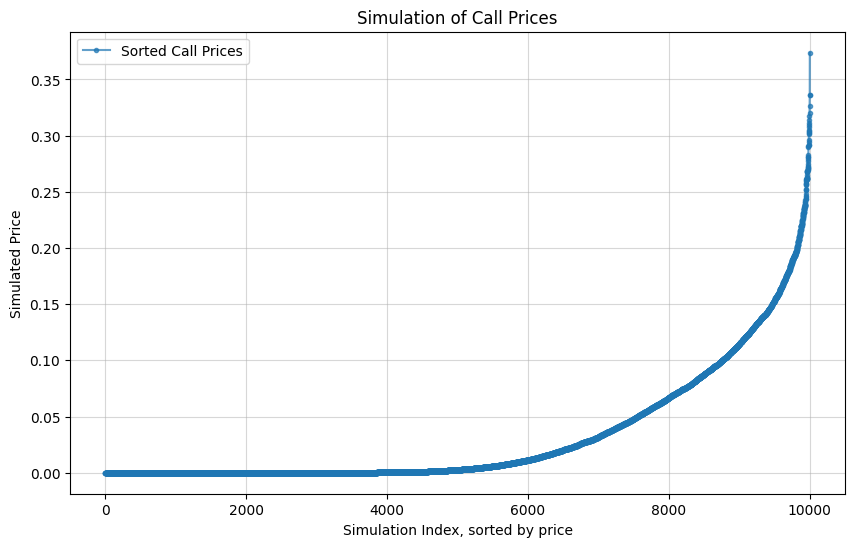

In [59]:
sorted_call_prices = np.sort(simulated_call_prices)
x_indices = range(1, len(simulated_call_prices) + 1)
plt.figure(figsize = (10, 6))
plt.plot(x_indices, sorted_call_prices, marker = 'o', linestyle = '-', markersize = 3, alpha = 0.7, label = "Sorted Call Prices")
plt.title("Simulation of Call Prices")
plt.ylabel("Simulated Price")
plt.xlabel("Simulation Index, sorted by price")
plt.legend(fontsize = 10)
plt.grid(True, alpha = 0.5)
plt.show()

To price the call while accounting for $95\%$ of the risk, we calculate the $95\%$ quantile of the distribution of simulated call prices.

In [60]:
import math
alpha = 0.95
VaR_Call = sorted(simulated_call_prices)[math.floor(alpha * N)]
VaR_Call

np.float64(0.15334585906587694)

According to our simulations, the price of the call should be less or equal to the result above.

# Question C : EVT

Once again, on the Natixis Stock :

In [61]:
df.head()

,date,price,price_return
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836


We separate the positive and negative returns. We also make them positive.

In [62]:
df_C = df["price_return"].copy()
df_C.dropna(inplace = True)
df_C_neg = abs(df_C[df_C < 0])
df_C_pos = df_C[df_C >= 0]

In [63]:
df_C_pos.head()

4     0.043836
7     0.025836
9     0.020523
10    0.013284
11    0.026038
Name: price_return, dtype: float64

In [64]:
df_C_neg.head()

1    0.035047
2    0.017515
3    0.019704
5    0.020723
6    0.014232
Name: price_return, dtype: float64

## A : Max-Domain of attraction parameter.

Let $(X_n)$ be a sequence of i.i.d. random variables, whose cdf $F$ belongs to the max-domain of attraction of a GEV distribution of parameter $\xi \in \mathbb{R}$. Let $k$ be a function $\mathbb{N} \to \mathbb{N}$. If
$$
\lim_{n \to \infty} k(n) = \infty
$$
and
$$
\lim_{n \to \infty} \frac{k(n)}{n} = 0,
$$
then, the pickhands estimator of the GEV parameter $\xi$ is given by :
$$
\xi_{k(n), n}^{P} = \frac{1}{\log(2)} \log\left(\frac{X_{n - k(n) + 1 : n} - X_{n - 2k(n) + 1 : n}}{X_{n - 2k(n) + 1 : n} - X_{n - 4k(n) + 1 : n}}\right),
$$
where $X_{i : n}$ represent the order statistics of the sample $(X_1, X_2, \dots, X_n)$, such that:
$$
X_{1:n} \leq X_{2:n} \leq \dots \leq X_{n:n}.
$$

We define the following functions :

In [65]:
k_1 = lambda n : n**(1/2)
k_2 = lambda n : n**(1/5)
k_3 = lambda n : np.log(n)

They all satify the condition for the convergence of the estimator. We compute the estimator :

In [66]:
import math #np.floor made the program crash for some reason...

def Pickands_estimator(data, k): # k is a function!
    n = len(data)
    data_sorted = np.sort(data)
    
    x_nk = data_sorted[math.floor(-k(n) + 1)]  # X_n-k(n)+1:n
    x_n2k = data_sorted[math.floor(-2*k(n) + 1)]  # X_n-2k(n)+1:n
    x_n4k = data_sorted[math.floor(-4*k(n) + 1)]  # X_n-4k(n)+1:n
    
    delta_num = x_nk - x_n2k
    delta_den = x_n2k - x_n4k
    delta = delta_num / delta_den
    
    return np.log(delta) / np.log(2)

Using $k_3$,

In [67]:
print(Pickands_estimator(df_C_neg, k_3))

-0.5263086875464077


So $\xi < 0$, the nature of the negative returns are of the Weibull kind. The tails of the negative returns are bounded. This isn't coherent with financial theory.

In [68]:
print(Pickands_estimator(df_C_pos, k_3))

0.5772338569463368


So $\xi > 0$, the nature of the positive returns are of the Fréchet kind. The tails of the positive returns are heavy. This isn't coherent with financial theory.

Let's plot a graph to see if it's coherent with our data :

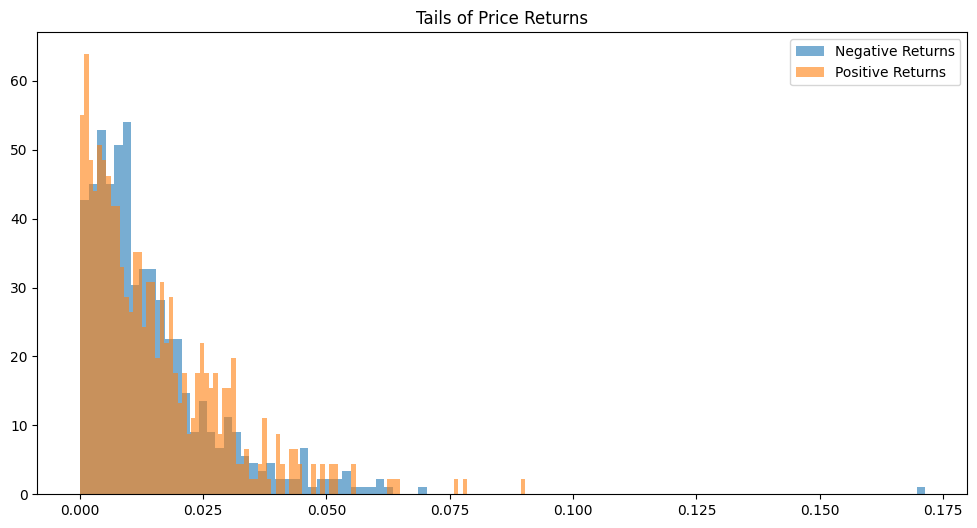

In [69]:
plt.figure(figsize=(12, 6))
plt.hist(df_C_neg, bins = 100, density = True, alpha = 0.6, label = "Negative Returns")
plt.hist(df_C_pos, bins = 100, density = True, alpha = 0.6, label = "Positive Returns")
plt.title("Tails of Price Returns")
plt.legend()
plt.show()

The value of $\xi$ seems coherent with the data. For the negative ones, probably because of the large hump at the begining and the lack of very poor returns (only one). Same for the postive returns, there is a hump near 0.025 making the distribution fatter, there are also more extreme returns.

In [70]:
print(len(df_C_neg), len(df_C_pos))

519 503


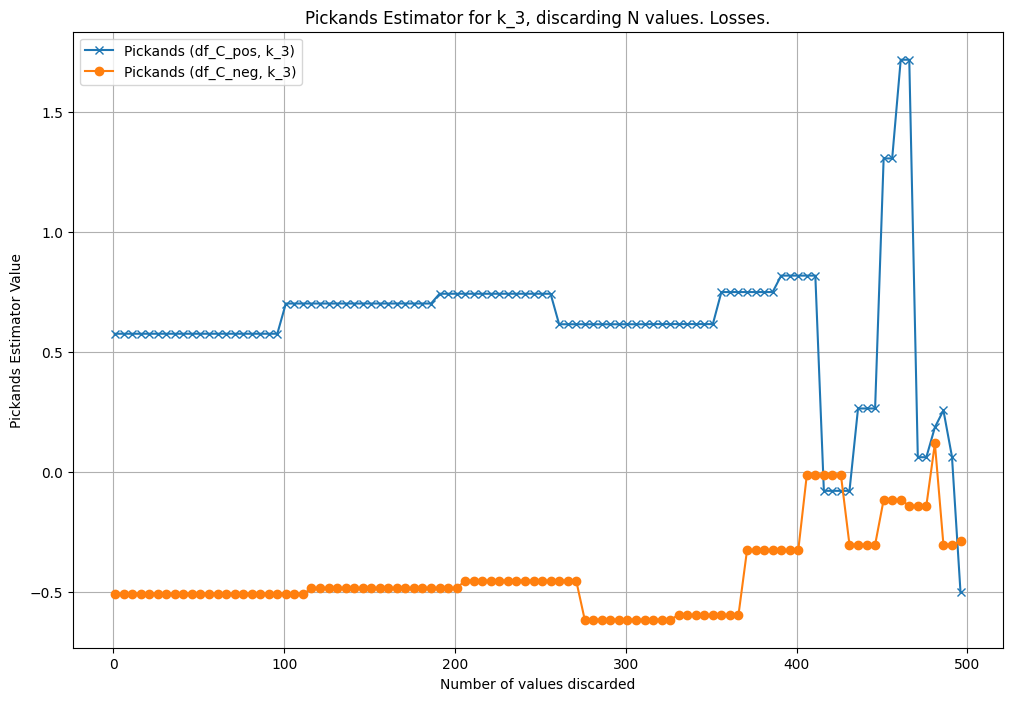

In [71]:
N_values = range(1, 500, 5) 
pickands_values_neg_k3, pickands_values_pos_k3 = [], []
for N in N_values:
    pickands_neg_k3 = Pickands_estimator(sorted(df_C_neg)[N:], k_3)
    pickands_pos_k3 = Pickands_estimator(sorted(df_C_pos)[N:], k_3)
    pickands_values_neg_k3.append(pickands_neg_k3)
    pickands_values_pos_k3.append(pickands_pos_k3)

plt.figure(figsize = (12, 8))
plt.plot(N_values, pickands_values_pos_k3, label = 'Pickands (df_C_pos, k_3)', marker = 'x')
plt.plot(N_values, pickands_values_neg_k3, label = 'Pickands (df_C_neg, k_3)', marker = 'o')
plt.xlabel('Number of values discarded')
plt.ylabel('Pickands Estimator Value')
plt.title('Pickands Estimator for k_3, discarding N values. Losses.')
plt.legend()
plt.grid()
plt.show()

In [72]:
N_values = range(1, 450, 5) 
pickands_values_neg_k1, pickands_values_pos_k1 = [], []
pickands_values_neg_k2, pickands_values_pos_k2 = [], []
pickands_values_neg_k3, pickands_values_pos_k3 = [], []

for N in N_values:
    pickands_neg_k1 = Pickands_estimator(sorted(df_C_neg)[N:], k_1)
    pickands_pos_k1 = Pickands_estimator(sorted(df_C_pos)[N:], k_1)
    pickands_values_neg_k1.append(pickands_neg_k1)
    pickands_values_pos_k1.append(pickands_pos_k1)

    pickands_neg_k2 = Pickands_estimator(sorted(df_C_neg)[N:], k_2)
    pickands_pos_k2 = Pickands_estimator(sorted(df_C_pos)[N:], k_2)
    pickands_values_neg_k2.append(pickands_neg_k2)
    pickands_values_pos_k2.append(pickands_pos_k2)

    pickands_neg_k3 = Pickands_estimator(sorted(df_C_neg)[N:], k_3)
    pickands_pos_k3 = Pickands_estimator(sorted(df_C_pos)[N:], k_3)
    pickands_values_neg_k3.append(pickands_neg_k3)
    pickands_values_pos_k3.append(pickands_pos_k3)

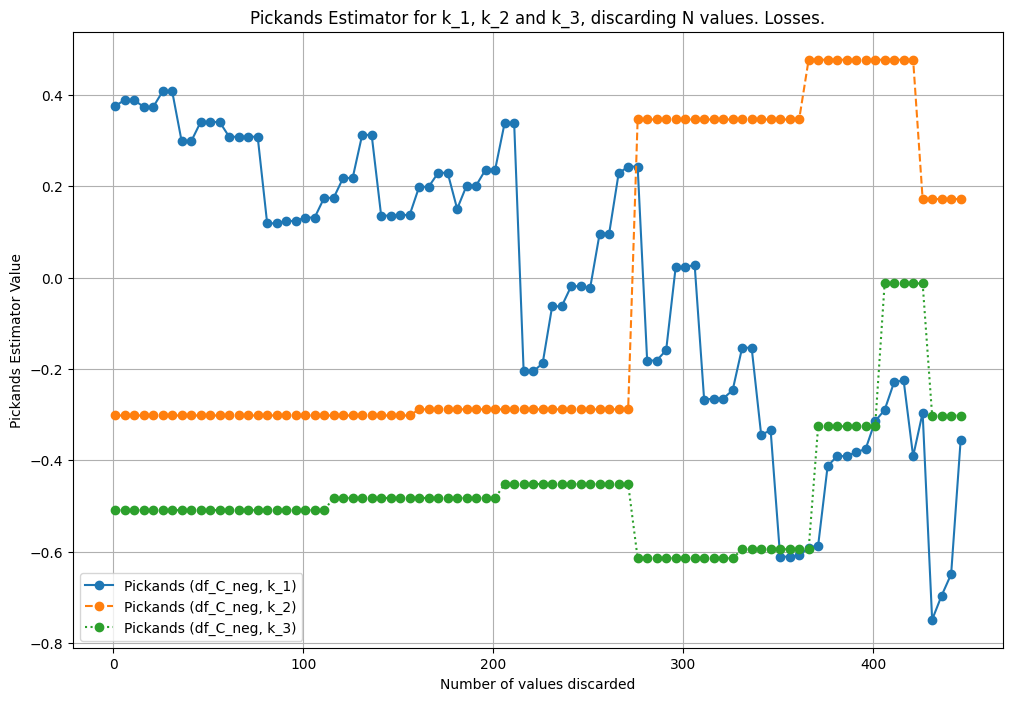

In [73]:
plt.figure(figsize = (12, 8))
plt.plot(N_values, pickands_values_neg_k1, label = 'Pickands (df_C_neg, k_1)', marker = 'o', linestyle = '-')
plt.plot(N_values, pickands_values_neg_k2, label = 'Pickands (df_C_neg, k_2)', marker = 'o', linestyle = '--')
plt.plot(N_values, pickands_values_neg_k3, label = 'Pickands (df_C_neg, k_3)', marker = 'o', linestyle = ':')
plt.xlabel('Number of values discarded')
plt.ylabel('Pickands Estimator Value')
plt.title('Pickands Estimator for k_1, k_2 and k_3, discarding N values. Losses.')
plt.legend()
plt.grid()
plt.show()

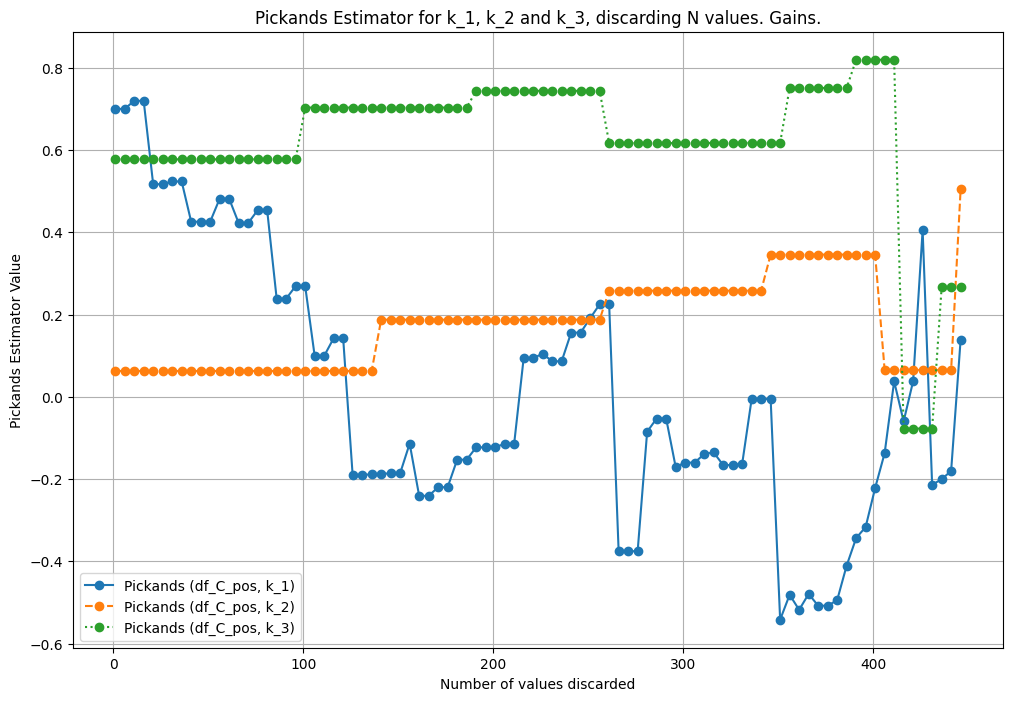

In [74]:
plt.figure(figsize=(12, 8))
plt.plot(N_values, pickands_values_pos_k1, label = 'Pickands (df_C_pos, k_1)', marker = 'o', linestyle = '-')
plt.plot(N_values, pickands_values_pos_k2, label = 'Pickands (df_C_pos, k_2)', marker = 'o', linestyle = '--')
plt.plot(N_values, pickands_values_pos_k3, label = 'Pickands (df_C_pos, k_3)', marker = 'o', linestyle = ':')
plt.xlabel('Number of values discarded')
plt.ylabel('Pickands Estimator Value')
plt.title('Pickands Estimator for k_1, k_2 and k_3, discarding N values. Gains.')
plt.legend()
plt.grid()
plt.show()

No sensible amount of discarded values gives the right result under financial theory.

### Bonus

On suppose les observations iid. La VaR pour le maximum de rv iid est :
$$ 
\text{VaR}(\alpha) = \frac{\left(\frac{k}{n(1 - \alpha)}\right)^{\xi^P} - 1}{1 - 2^{-\xi^P}}(X_{n - k + 1: n} - X_{n - 2k + 1: n}) + X_{n - k + 1: n}
$$
pour $k$ fixé et $n$ large.

On implémente les deux versions.

In [75]:
def VaR_pickhands(data, k, K, alpha):
    data_sorted = np.sort(data)
    xi = Pickands_estimator(data, K)
    print('xi = ', xi)
    n = len(data_sorted)
    
    X_1 = data_sorted[n - k] # X_{n - k + 1 : n}
    X_2 = data_sorted[n - 2 * k] # X_{n - 2k + 1 : n}
    
    coef = ((k / (n * (1 - alpha))) ** xi - 1) / (1 - 2 ** (-xi))

    return  coef * (X_1 - X_2) + X_1

In [76]:
alpha = 0.95
var_pickands = VaR_pickhands(df_C_neg, 3, k_3, alpha)
print('VaR Pickands = ', var_pickands)

xi =  -0.5263086875464077
VaR Pickands =  0.04069861601611689


## B : Extremal index

We want to compute the quantities :
$$
\hat{\theta}_n^B(u; b) = \frac{\sum_{i=1}^k \mathbb{1}(M_{(i-1)b, ib} > u)}{\sum_{i=1}^{kb} \mathbb{1}(X_i > u)} \quad \text{and} \quad \hat{\theta}_n^R(u; r) = \frac{\sum_{i=1}^{n-r} \mathbb{1}(X_i > u, M_{i+1, i+r} \leq u)}{\sum_{i=1}^n \mathbb{1}(X_i > u)}.
$$

Where $b$ is the size of the blocks, $u$ a threshold and $r$ an arbitrary slinding window.

We are going to compute both quantities for comparison sake,

In [77]:
def extremal_index_blocks(data, u, b):
    # Divide data into blocks, DO NOT SORT ! (order is important, we are testing independance of the extremes)
    n_blocks = len(data) // b
    blocks = [data[i * b: (i + 1) * b] for i in range(n_blocks)]
    
    # Count the number of blocks with at least one value over the threshold.
    cluster_count = sum(1 for block in blocks if np.max(block) > u)
    
    # Count the total number of observations over the threshold.
    over_thresh = np.sum(data > u)
    
    theta = cluster_count / over_thresh if over_thresh > 0 else 0
    return theta

For blocks declustering. And :

In [78]:
def extremal_index_runs(data, u, r):
    data = np.array(data)
    # Identify observations over the threshold.
    over_thresh = data > u
    n_over_thresh = over_thresh.sum()
    
    # De-cluster exceedances into clusters
    clusters = 0
    gap = 0  # Track gap between exceedances
    for i in range(len(data)):
        if over_thresh[i]:
            if gap >= r:  # Start of a new cluster after r gaps
                clusters += 1
            gap = 0  # Reset gap after an exceedance
        else:
            gap += 1  # Increment gap during non-exceedances
    
    theta = clusters / n_over_thresh if n_over_thresh > 0 else 0
    return theta

For Runs declustering. We get :

In [79]:
extremal_index_blocks(df_C, 0.04, 10)

np.float64(0.7931034482758621)

In [80]:
extremal_index_runs(df_C, 0.04, 10)

np.float64(0.6206896551724138)

The code seems to work. Let's see how sensitive it is :

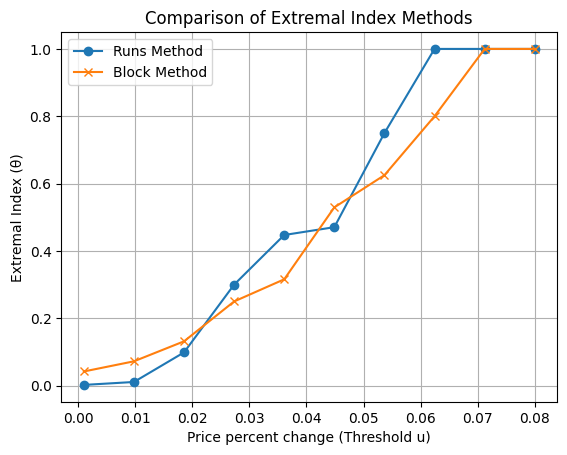

In [81]:
thresholds = np.linspace(0.001, 0.08, 10)  # Extend to higher thresholds

theta_runs = [extremal_index_runs(df_C, u, 15) for u in thresholds]
theta_block = [extremal_index_blocks(df_C, u, b = 50) for u in thresholds]

plt.plot(thresholds, theta_runs, label = "Runs Method", marker = 'o')
plt.plot(thresholds, theta_block, label = "Block Method", marker = 'x')
plt.title("Comparison of Extremal Index Methods")
plt.xlabel("Price percent change (Threshold u)")
plt.ylabel("Extremal Index (θ)")
plt.legend()
plt.grid()
plt.show()

This suggests that higher extremes are more independent compared to smaller extremes. Both computation methods give the same result.

# Question D : Almgren & Chriss

We import the new set of data :

In [82]:
df_D = pd.read_csv('data/Dataset TD4.csv', sep = ";")
df_D.columns = ["t_k", "ba_spread", "n_k", "sgn", "S_prev"]
df_D["t_k"] = df_D["t_k"].str.replace(',', '.').astype(float)
df_D["S_prev"] = df_D["S_prev"].str.replace(',', '.').astype(float)
df_D["ba_spread"] = df_D["ba_spread"].str.replace(',', '.').astype(float)
print(df_D.head())
print(df_D.columns)

        t_k  ba_spread  n_k  sgn   S_prev
0  0.000202     0.1100  8.0   -1  100.000
1  0.001070     0.1030  NaN    1   99.984
2  0.001496     0.1015  NaN   -1  100.029
3  0.003336     0.0920  NaN    1   99.979
4  0.003952     0.1106  NaN    1  100.060
Index(['t_k', 'ba_spread', 'n_k', 'sgn', 'S_prev'], dtype='object')


Computation of $\tau$. We are going to average the times in between executions :

In [83]:
tau = df_D["t_k"].diff().mean() * 24  # since t_k = 1 corresponds to 24 hours
print(tau)

0.023803199999999997


Since $t_k = 1 \Leftrightarrow t_k = 24 \text{ hrs}$, $\tau = 24 \times t$ 

In [84]:
tau * 60

np.float64(1.4281919999999997)

So there is a transaction every minute and a half approximatly.

## a) Estimation of the parameters.

The price is supposed to follow the following model :
$$
S_k = S_{k - 1} + \sigma \sqrt{\tau} \varepsilon_k - \tau g\left(\frac{n_k}{\tau}\right), \quad (1)
$$
With :
- $S_k$: Observed price at time $k$.
- $S_{k - 1}$ : Observed price at the previous time step.
- $\sigma$ : Volatility.
- $\tau$ : Time step size.
- $\varepsilon_k$ : Noise $\sim \mathcal{N}(0,1)$.
- $g(v) := \gamma v$ : Permanent price impact function.
- $n_k$ : Trading volume at time $k$.

Estimation of $\gamma$ :

From the price model :
$$
\Delta S_k := S_k - S_{k - 1} = \sigma \sqrt{\tau} \varepsilon_k - \gamma n_k \Leftrightarrow \frac{\Delta S_k}{n_k} = \frac{\sigma \sqrt{\tau}}{n_k} \varepsilon_k - \gamma. 
$$
By linearity of the gaussian distribution :
$$
\frac{- \Delta S_k}{n_k} \sim \mathcal{N}\left(\gamma, \tau \left(\frac{\sigma}{n_k}\right)^2\right).
$$

We define the first moment estimator of $\gamma$ :
$$
\hat{\gamma}_n = \frac1n \sum_{i = 1}^n \frac{S_{k - 1} - S_k}{n_k}
$$
By the law of large numbers, supposing the $\varepsilon_i$ iid, $\hat{\gamma}_n$ is a consistent estimator of $\gamma$ : 
$$
\hat{\gamma}_n \overset{d}{\underset{n \to +\infty}{\longrightarrow}} \mathbb{E}[\hat{\gamma}_n] = \gamma.
$$

Let's compute the values :

In [85]:
# Create S_current by shifting S_prev backward
df_D["S_current"] = df_D["S_prev"].shift(-1)
df_D["delta_S_k"] = df_D["S_current"] - df_D["S_prev"]
df_D["delta_S_k_per_nk"] = df_D["delta_S_k"] / df_D["n_k"]
df_cleaned_gamma = df_D.dropna(subset = ["delta_S_k", "delta_S_k_per_nk"]) # Drop the last row which contains NaN in S_current

Then we estimate $\gamma$ :

In [86]:
gamma_hat = - df_cleaned_gamma["delta_S_k_per_nk"].mean()
print(gamma_hat)

2.1185612030126003e-05


Giving :
$$
\hat{\gamma}_n = 2.1185612030126003 \cdot 10^{-5}.
$$
According to the original paper, this is coherent with a less liquid kind of security ($10^{-5}$ to $10^{-4}$ range). We don't actually know the stock that the data comes from so we cannot confirm that.

If we take different trading volumes, it would mean that the estiamted price impact is :

In [87]:
simulated_impact = gamma_hat * np.array([100, 500, 1000])  # Example volumes
print(simulated_impact)

[0.00211856 0.01059281 0.02118561]


A buy of 1000 units of the security are estimated to make the stock price increase by $2.1\%$.

We compute the volatility $\mathbf{\text{over a single time step}}$:

In [88]:
tau_seconds = df_D["t_k"].diff().mean() * 24 * 3600  # Convert tau to seconds
sigma = df_D["delta_S_k"].std() / np.sqrt(tau_seconds)
print(sigma)

0.007959305124720978


In [89]:
df_D["xi"] = df_D["ba_spread"] / 2

At time $k$, we observe a price that has been impacted by the transaction at $k - 1$ :
$$
\overline{S}_k = S_k - h\left(\frac{n_k}{\tau}\right)
$$
where:
- $h(x) = \xi \cdot \text{sgn}(n_k) + \eta \frac{n_k}{\tau}$ : Temporary market impact function.
- $\xi$ : Half the bid-ask spread.
- $\eta$ : Coefficient.

Substituting in the equations, we get  :
$$
\overline{S}_k - S_{k-1} = \sigma \sqrt{\tau} \varepsilon_k - \gamma n_k - \xi \text{sgn}(n_k) - \eta \frac{n_k}{\tau}
$$

We rearrange the terms :
$$
-\tau \frac{\Delta S_k + \gamma n_k + \xi \text{sgn}(n_k)}{n_k} = \eta - \frac{\sigma \tau^{3/2} \varepsilon_k}{n_k}, \quad (2)
$$

Since we have estimated the value of $\gamma$,
$$
- \tau \frac{\Delta S_k + \hat{\gamma}_n n_k + \xi \text{sgn}(n_k)}{n_k} = -\tau \frac{\Delta S_k + (\hat{\gamma}_n - \gamma + \gamma) n_k + \xi \text{sgn}(n_k)}{n_k} = -\tau \frac{\Delta S_k +  \gamma n_k + \xi \text{sgn}(n_k)}{n_k} - \tau(\hat{\gamma}_n - \gamma) =: X_k
$$

Taking $\mathbb{E}(2)$ :
$$
\mathbb{E}\left[-\tau\frac{\Delta S_k +  \gamma n_k + \xi \text{sgn}(n_k)}{n_k}\right] = \eta - 0 = \eta, \quad \text{since } \frac{\sigma \tau^{3/2} \varepsilon_k}{n_k} \sim \mathcal{N}(0, m > 0).
$$

By the LLN,
$$
\hat{\eta}_n := \frac1n \sum_{i = 1}^n X_k \overset{d}{\underset{n \to +\infty}{\longrightarrow}} \mathbb{E}\left[-\tau \frac{\Delta S_k +  \gamma n_k + \xi \text{sgn}(n_k)}{n_k}\right] + \tau(\gamma - \gamma) = \eta,
$$
since $\hat{\gamma}_n$ is a consistent estimator of $\gamma$. Hence $\hat{\eta}_n$ is also a consistent estimator of $\eta$. We could have all of this in one go...

To compute its values, we first shift the values in the dataframe :

In [90]:
df_D_eta = df_D.copy()
df_D_eta['shifted_n'] = df_D_eta['n_k'].shift(1)
df_D_eta['shifted_sgn'] = df_D_eta['sgn'].shift(1)
df_D_eta['shifted_xi'] = df_D_eta['xi'].shift(1)
df_D_eta.head()

,t_k,ba_spread,n_k,sgn,S_prev,S_current,delta_S_k,delta_S_k_per_nk,xi,shifted_n,shifted_sgn,shifted_xi
0,0.000202,0.1100,8.0,-1,100.000,99.984,-0.016,-0.002,0.05500,NaN,NaN,NaN
1,0.001070,0.1030,NaN,1,99.984,100.029,0.045,NaN,0.05150,8.0,-1.0,0.05500
2,0.001496,0.1015,NaN,-1,100.029,99.979,-0.050,NaN,0.05075,NaN,1.0,0.05150
3,0.003336,0.0920,NaN,1,99.979,100.060,0.081,NaN,0.04600,NaN,-1.0,0.05075
4,0.003952,0.1106,NaN,1,100.060,100.160,0.100,NaN,0.05530,NaN,1.0,0.04600


In [91]:
df_D_eta['tmp_for_eta'] = tau * (df_D_eta['delta_S_k'] + gamma_hat * df_D_eta['shifted_n'] + df_D_eta['shifted_xi'] * df_D_eta['shifted_sgn']) / df_D_eta['shifted_n']
eta_hat = -df_D_eta['tmp_for_eta'].mean()
print(eta_hat)

5.2210599841788345e-06


Hence we find the value :
$$
\eta \approx 2.9240658482954894 \cdot 10^{-6}.
$$
It is a coherent value with what we obtained above.

We now check that the model is well specified. The residual should follow a normal distribution of mean $0$ :

$$
\varepsilon_k = \frac{\Delta S_k + \hat{\gamma} n_k + \xi \cdot \text{sgn}(n_k)}{\sigma \sqrt{\tau} \cdot n_k} - \frac{\hat{\eta}}{\sigma \sqrt{\tau}} \sim \mathcal{N}(0, 0 < m < 1)
$$

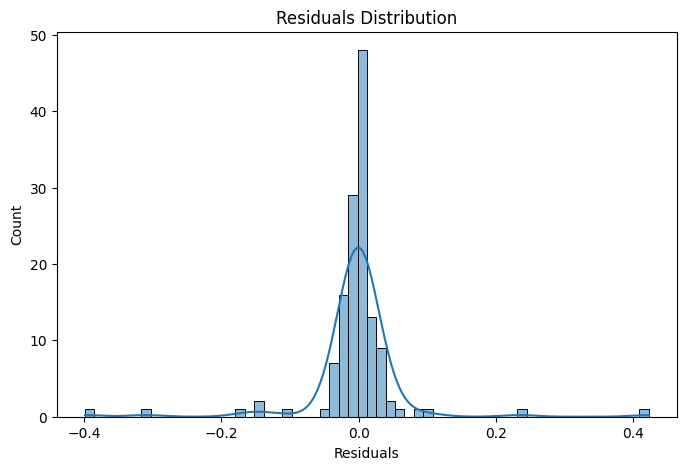

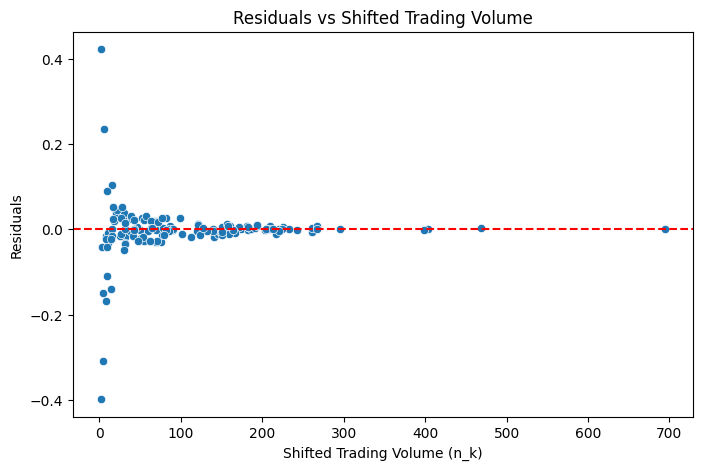

Residuals Mean: -0.003047865111213066
Residuals Std Dev: 0.06830616329835561


In [92]:
import seaborn as sns # Just to look at the kde of the residuals...
# Compute residuals based on the model
df_D_eta['residuals'] = (df_D_eta['delta_S_k'] + gamma_hat * df_D_eta['shifted_n'] + df_D_eta['shifted_xi'] * df_D_eta['shifted_sgn']) / (sigma * np.sqrt(tau_seconds) * df_D_eta['shifted_n']) - eta_hat / (sigma * np.sqrt(tau_seconds))
# Drop NaN values
residuals = df_D_eta['residuals'].dropna()

# Plot histogram of residuals
plt.figure(figsize = (8, 5))
sns.histplot(residuals, kde = True, bins = 60) # Here.
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()

# Plot residuals vs shifted_n
plt.figure(figsize = (8, 5))
sns.scatterplot(x = df_D_eta['shifted_n'], y = df_D_eta['residuals'])
plt.xlabel('Shifted Trading Volume (n_k)')
plt.ylabel('Residuals')
plt.title('Residuals vs Shifted Trading Volume')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Print summary statistics of residuals
print("Residuals Mean:", residuals.mean())
print("Residuals Std Dev:", residuals.std())


The residual follow a Bell curve of mean near $0$ and the residuals are close to zero in the residuals vs $n_k$ plot. The standard deviation is less than what was expected, meaning that the model interpolates the values better than expected. The shape of the plot also indicates that the the deviation decreases with $n_k$.

Now, we compute the coeficient $R^2$ :

In [93]:
df_D_eta['predicted'] = - (gamma_hat * df_D_eta['shifted_n'] + df_D_eta['shifted_xi'] * df_D_eta['shifted_sgn'] + eta_hat * df_D_eta['shifted_n'] / tau_seconds)
df_D_eta['residuals'] = df_D_eta['delta_S_k'] - df_D_eta['predicted']
Sum_Squares_residual = (df_D_eta['residuals'] ** 2).sum()
Sum_Squares_total = ((df_D_eta['delta_S_k'] - df_D_eta['delta_S_k'].mean()) ** 2).sum()
R_squared = 1 - (Sum_Squares_residual / Sum_Squares_total)
print("R^2:", R_squared)

R^2: 0.8355899889571641


## b) Liquidation strategy :

Each tranche is computed such that :
$$
x_k = \frac{\sinh(K(T - (k - \frac{\tau}{2})))}{\sinh(KT)}X.
$$
Where :
- $X$ : Total quantity to liquidate.
- $T = 1 \text{ day}$ : Time to do so.
- $k$ : Trading period, one tick.
- $K \approx \sqrt{\frac{\lambda \sigma^2}{\eta}}$ with $\lambda$ the risk aversion. 

If we rewrite the equation like in the paper,
$$
x_j = \frac{\sinh(K(T - (j - 1/2) \tau))}{\sinh(KT)}X.
$$
where :
   - $j$ : The index of the trading interval, ranging from $1$ to $N$, where $N$ is the total number of intervals.
   - $\tau = \frac{T}{N}$ :  The duration of each trading interval.

The data has one trading day of transactions so 24 hrs. We can only do one trade per hour.

In [97]:
X = 1000
T = 1
N = 24 # Trading periods.
tau_liq = T / N
lambda__ = 10**(-7)
K = np.sqrt(sigma**2 * lambda__/ eta_hat)

x_N = np.sinh(K * (T - (np.arange(1, N + 1) - 0.5) * tau_liq)) / np.sinh(K * T) * X # Amount of shares at each time step.
liq_N = x_N / np.sum(x_N) * X  # Amount sold at each time step.

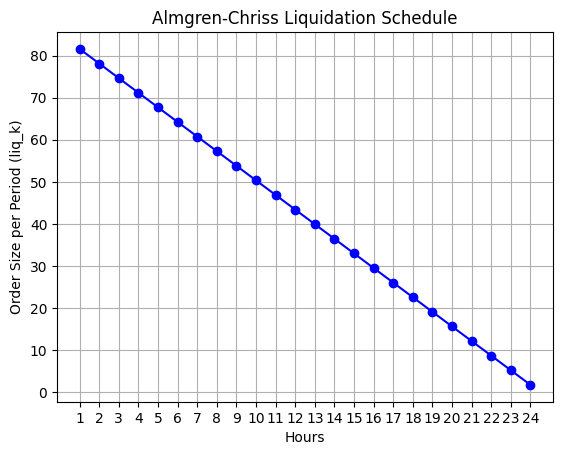

In [98]:
plt.figure()
plt.plot(range(1, N + 1), liq_N, marker = 'o', linestyle = '-', color = 'blue')
plt.xlabel('Hours')
plt.ylabel('Order Size per Period (liq_k)')
plt.title('Almgren-Chriss Liquidation Schedule')
plt.grid(True)
plt.xticks(range(1, N + 1))
plt.show()

In [99]:
print("Liquidation Schedule :")
for i in range(len(liq_N)):
    print(f"Hour {i + 1} : {liq_N[i]} shares")

Liquidation Schedule :
Hour 1 : 81.59722979959986 shares
Hour 2 : 78.12500599320799 shares
Hour 3 : 74.65278235138935 shares
Hour 4 : 71.18055886682957 shares
Hour 5 : 67.70833553221429 shares
Hour 6 : 64.23611234022916 shares
Hour 7 : 60.76388928355978 shares
Hour 8 : 57.29166635489178 shares
Hour 9 : 53.81944354691084 shares
Hour 10 : 50.347220852302556 shares
Hour 11 : 46.87499826375255 shares
Hour 12 : 43.40277577394649 shares
Hour 13 : 39.93055337556998 shares
Hour 14 : 36.45833106130866 shares
Hour 15 : 32.9861088238482 shares
Hour 16 : 29.51388665587419 shares
Hour 17 : 26.041664550072284 shares
Hour 18 : 22.569442499128115 shares
Hour 19 : 19.09722049572732 shares
Hour 20 : 15.624998532555521 shares
Hour 21 : 12.152776602298372 shares
Hour 22 : 8.680554697641503 shares
Hour 23 : 5.208332811270532 shares
Hour 24 : 1.7361109358711198 shares


In [100]:
liq_N.sum()

np.float64(1000.0)

In [156]:
liq_N_rounded = np.round(liq_N).astype(int)

In [157]:
print("Adjusted Liquidation Schedule :")
for i, shares in enumerate(liq_N_rounded):
    if i == 0 :
        print(f"Hour {i + 1} : {shares + 1} shares")
    else :
        print(f"Hour {i + 1} : {shares} shares")
print(sum(liq_N_rounded) + 1)

Adjusted Liquidation Schedule :
Hour 1 : 138 shares
Hour 2 : 120 shares
Hour 3 : 104 shares
Hour 4 : 91 shares
Hour 5 : 79 shares
Hour 6 : 69 shares
Hour 7 : 60 shares
Hour 8 : 52 shares
Hour 9 : 46 shares
Hour 10 : 40 shares
Hour 11 : 34 shares
Hour 12 : 30 shares
Hour 13 : 26 shares
Hour 14 : 22 shares
Hour 15 : 19 shares
Hour 16 : 16 shares
Hour 17 : 14 shares
Hour 18 : 11 shares
Hour 19 : 9 shares
Hour 20 : 7 shares
Hour 21 : 6 shares
Hour 22 : 4 shares
Hour 23 : 2 shares
Hour 24 : 1 shares
1000


We've successfully computed the optimal liquidation strategy according to Almgren and Chriss. Having access to a dark pool would be better though.

# Question E : Wavelets and Hurst exponent.

After seperating the dataset of each exchange rate, we import the following dtaframes :

In [158]:
df_CADEUR = pd.read_csv('data/TD5_CADEUR.csv', sep=	';', decimal=',', header = 1) 
df_CADEUR["HL_avg"] = 0.5 * (df_CADEUR["HIGH"] + df_CADEUR["LOW"])
df_CADEUR.head()

,Date,HIGH,LOW,HL_avg
0,07/03/2016 09:00,0.6842,0.6829,0.68355
1,07/03/2016 09:15,0.6849,0.6841,0.68450
2,07/03/2016 09:30,0.6844,0.6837,0.68405
3,07/03/2016 09:45,0.6844,0.6839,0.68415
4,07/03/2016 10:00,0.6840,0.6835,0.68375


In [159]:
df_GBPEUR = pd.read_csv('../data/TD5_GBPEUR.csv', sep=	';', decimal=',', header = 1) 
df_GBPEUR["HL_avg"] = 0.5 * (df_GBPEUR["HIGH"] + df_GBPEUR["LOW"])
df_GBPEUR.head()

,Date,HIGH,LOW,HL_avg
0,07/03/2016 09:00,1.2932,1.2917,1.29245
1,07/03/2016 09:15,1.2940,1.2930,1.29350
2,07/03/2016 09:30,1.2943,1.2922,1.29325
3,07/03/2016 09:45,1.2930,1.2913,1.29215
4,07/03/2016 10:00,1.2931,1.2921,1.29260


In [160]:
df_SEKEUR = pd.read_csv('data/TD5_SEKEUR.csv', sep=	';', decimal=',', header = 1) 
df_SEKEUR["HL_avg"] = 0.5 * (df_SEKEUR["HIGH"] + df_SEKEUR["LOW"])
df_SEKEUR.head()

,Date,HIGH,LOW,HL_avg
0,07/03/2016 09:00,0.10725,0.10720,0.107225
1,07/03/2016 09:15,0.10728,0.10717,0.107225
2,07/03/2016 09:30,0.10726,0.10719,0.107225
3,07/03/2016 09:45,0.10728,0.10721,0.107245
4,07/03/2016 10:00,0.10725,0.10719,0.107220


## a) Haar transform for correlation.

We begin with a bit of theory.

The Haar mother wavelet is given by :
$$
\psi^{Haar} : t \in \mathbb{R} \mapsto \mathbf{1}_{[0, 1/2)}(t) - \mathbf{1}_{[1/2, 2)}(t).
$$

And the scaling function :
$$
\phi : t \mapsto \mathbf{1}_{[0,1]}(t).
$$

We know that the scaling function satisfies the recursive relation :
$$
\phi(x) = \sum_{k = 0}^{2N - 1} a_k \phi(2x - k)
$$

In our case, there is one vanishing moment so $N = 1$, giving :
$$
\phi(x) = a_0 \phi(2x) + a_1 \phi(2x - 1)
$$

Since the scaled components are othogonal :
$$
\|\phi(x)\|^2_{L^2} = \|a_0 \phi(2x) + a_1 \phi(2x - 1)\|^2_{L^2} = \|a_1\phi(2x)\|^2_{L^2} + \|a_2\phi(2x - 1)\|^2_{L^2} = |a_0|^2 \|\phi(2x)\|^2_{L^2} + |a_1|^2 \|\phi(2x - 1)\|^2_{L^2}
$$

Assuming $a_0 = a_1$, the normalization condition $\|\phi(x)\|_{L^2} = \|\phi(2x)\|_{L^2} = \|\phi(2x - 1)\|_{L^2} = 1$, gives :
$$
a_0 = a_1 = \frac{1}{\sqrt{2}}.
$$

For the one level Haar transform :

Consider an observation $X = (x_1, \dots, x_n)$ where $n$ is even. The approximation coefficient are given by :
$$
a_{k - 1} = \frac{x_{2k} + x_{2k + 1}}{\sqrt{2}}
$$
The detail coefficient are :
$$
d_k = \frac{x_{2k} - x_{2k + 1}}{\sqrt{2}}.
$$

In [161]:
def haar_transform_single(signal):
    n = len(signal)
    if n % 2 != 0:
        raise ValueError("Signal length must be even for Haar transform.") # See the loop below...
    approximation = []
    detail = []
    for i in range(0, n, 2):
        a = (signal[i] + signal[i + 1]) / np.sqrt(2)
        d = (signal[i] - signal[i + 1]) / np.sqrt(2)
        approximation.append(a)
        detail.append(d)
    
    return np.array(approximation), np.array(detail)

Then, we apply the algorithm recursively to get the different levels. We compute the one level transformation of the data, then the one level approximation of the one level approximation which is the second level approximation, ...

In [162]:
def haar_transform_recursive(signal, max_levels = None):
    coefficients = []
    current_signal = signal
    level = 0
    
    while len(current_signal) >= 2:
        if max_levels is not None and level >= max_levels:
            break  # Stop if the desired number of levels is reached
        
        # Ensure the signal length is even by truncating if necessary
        if len(current_signal) % 2 != 0:
            current_signal = current_signal[:-1]  # Truncate the last value
        
        # Perform one level of the Haar transform
        approximation, detail = haar_transform_single(current_signal)
        coefficients.append((approximation, detail))
        
        # Continue with the approximation coefficients
        current_signal = approximation
        level += 1  # Increment the level counter
    
    return coefficients # Returns tupples of approximation AND detail coefficients

In [163]:
len(df_CADEUR["HL_avg"].values)

12929

We need an even number of observations, we just remove the first one and apply the algorithm :

In [164]:
coefs_cadeur = haar_transform_recursive(df_CADEUR["HL_avg"].iloc[1:].values, 10) # Skip the first value (to make the signal length even).

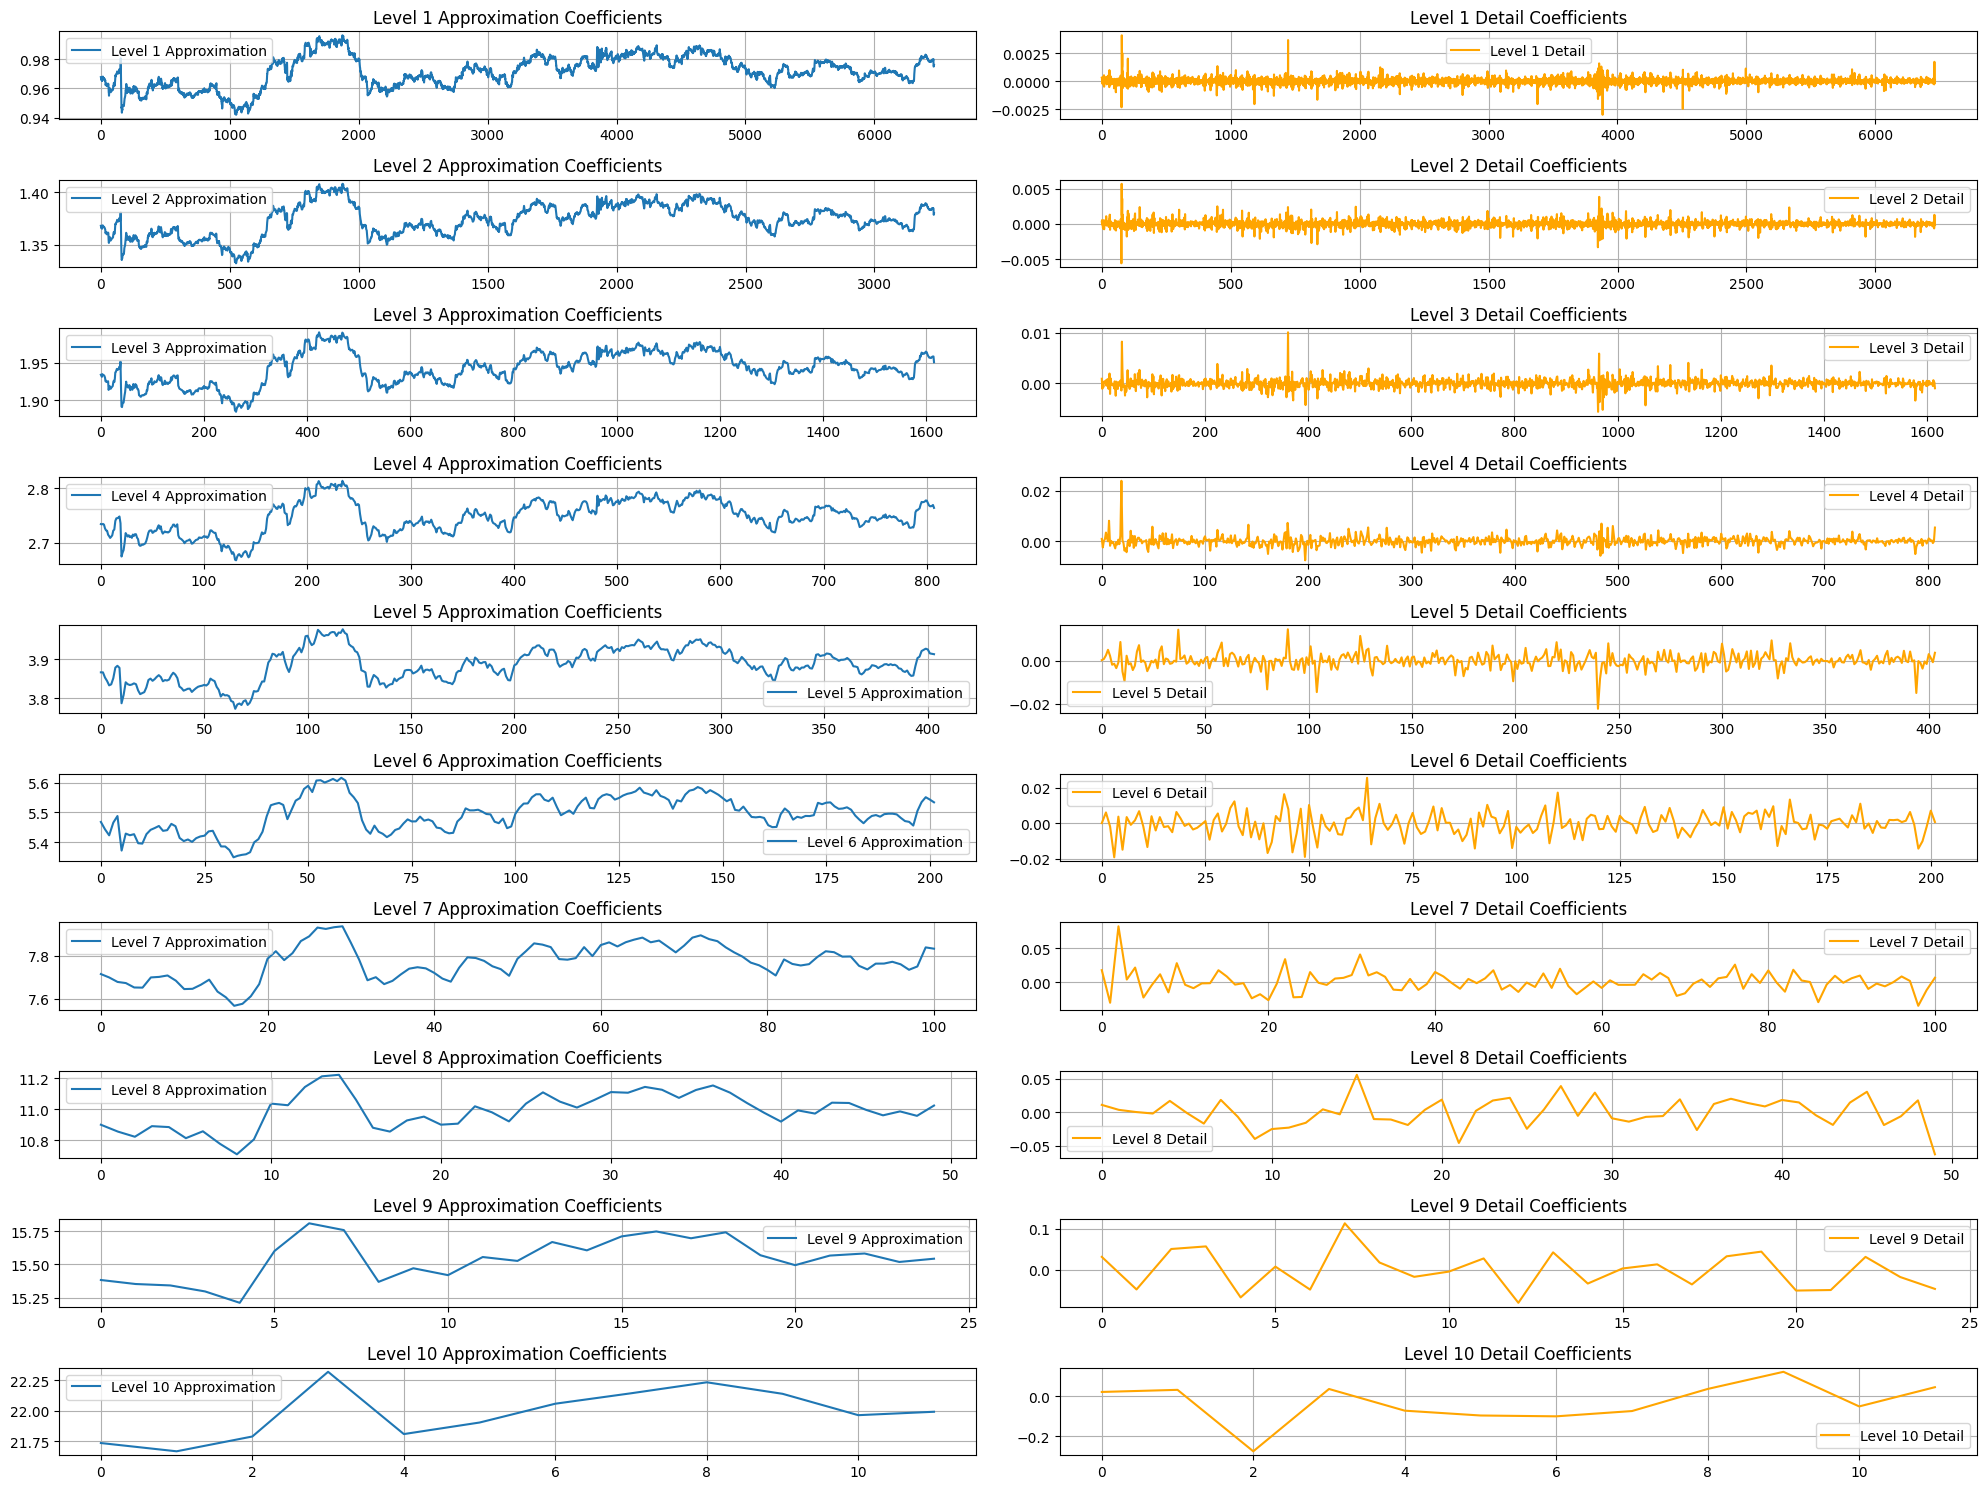

In [165]:
plt.figure(figsize = (20 , 15))
for level, (approximation, detail) in enumerate(coefs_cadeur):
    # Plot approximation coefficients
    plt.subplot(len(coefs_cadeur), 2, 2 * level + 1)
    plt.plot(approximation, label = f'Level {level + 1} Approximation')
    plt.title(f'Level {level + 1} Approximation Coefficients')
    plt.legend()
    plt.grid()
    # Plot detail coefficients
    plt.subplot(len(coefs_cadeur), 2, 2 * level + 2)
    plt.plot(detail, label = f'Level {level + 1} Detail', color = 'orange')
    plt.title(f'Level {level + 1} Detail Coefficients')
    plt.legend()
    plt.grid()
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

We will check our results with the inverse Haar transform. It also works recursively :

In [166]:
def haar_inverse_single(approx, detail):
    n = len(approx)
    reconstructed = np.zeros(2*n)
    for k in range(n):
        reconstructed[2*k]   = (approx[k] + detail[k]) / np.sqrt(2)
        reconstructed[2*k + 1] = (approx[k] - detail[k]) / np.sqrt(2)
    return reconstructed

In [167]:
def haar_inverse_recursive(coeffs):
    approximation, detail = coeffs[-1]
    # Reconstruct the approximation at the previous scale
    current_signal = haar_inverse_single(approximation, detail)
    for level in range(len(coeffs) - 2, -1, -1):
        old_approx, old_detail = coeffs[level]
        current_signal = haar_inverse_single(current_signal, old_detail)
    return current_signal

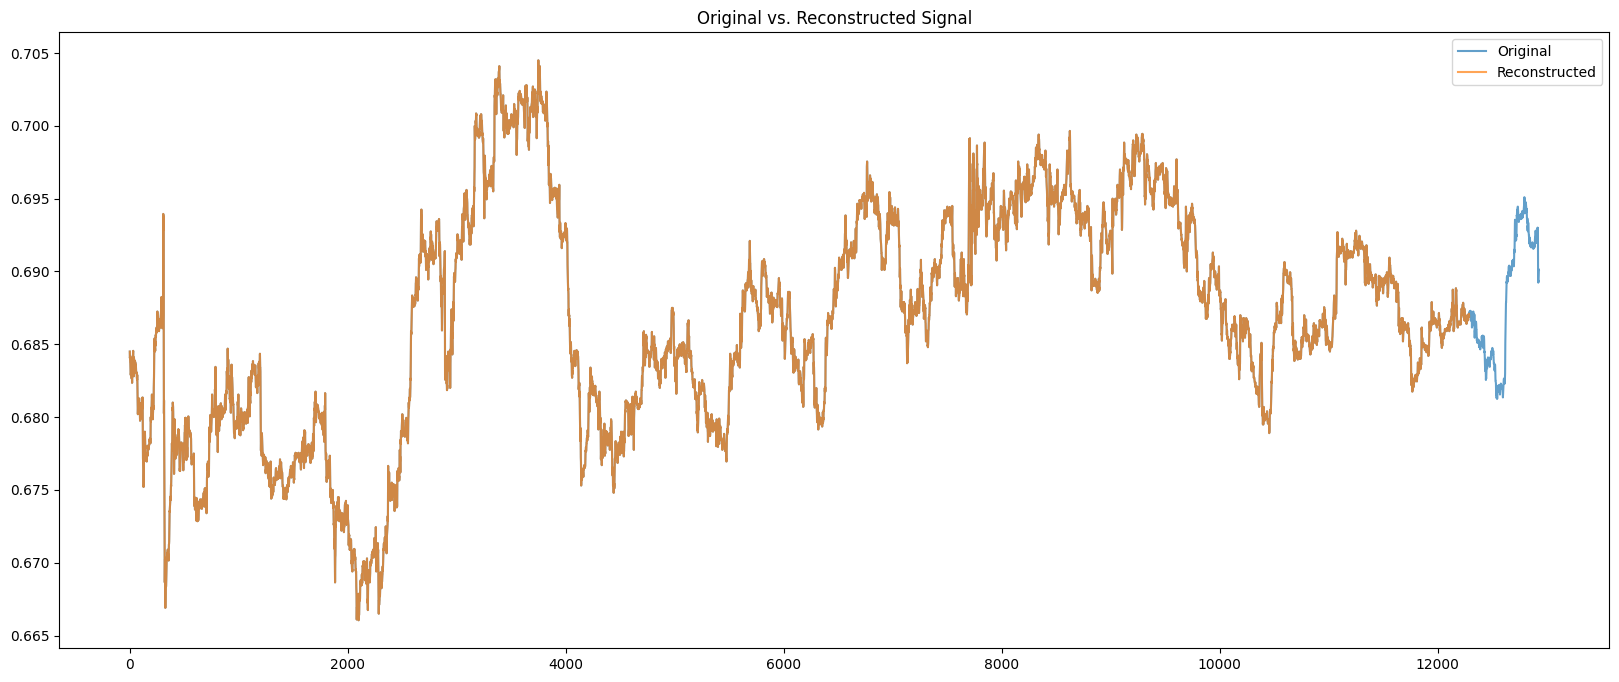

In [168]:
original_signal = df_CADEUR["HL_avg"].iloc[1:].values
reconstructed_signal = haar_inverse_recursive(coefs_cadeur)

plt.figure(figsize = (20,8))
plt.plot(original_signal, label = "Original", alpha = 0.7)
plt.plot(reconstructed_signal, label = "Reconstructed", alpha = 0.7)
plt.title("Original vs. Reconstructed Signal")
plt.legend()
plt.show()

Although we've seemed to have reconstructed the signal correctly, we do not undersant why the length of the reconstructed signal gets lower and lower as we increase the approximation levels and coeficients computed.

Now that we have a working Haar transform algorithm, we proceed with the correlation analysis :

In [169]:
coefs_cadeur = haar_transform_recursive(df_CADEUR["HL_avg"].iloc[1:].values)
coefs_gbpeur = haar_transform_recursive(df_GBPEUR["HL_avg"].iloc[1:].values)
coefs_sekeur = haar_transform_recursive(df_SEKEUR["HL_avg"].iloc[1:].values)

In [170]:
correlations = []
for level, (coef_cadeur, coef_gbpeur, coef_sekeur) in enumerate(zip(coefs_cadeur, coefs_gbpeur, coefs_sekeur)):
    # We get the wavelet approximation coefficients :
    approx_cadeur, _ = coef_cadeur
    approx_gbpeur, _ = coef_gbpeur
    approx_sekeur, _ = coef_sekeur

    # Compute the correlations between the approximations :
    corr_cadeur_gbpeur = np.corrcoef(approx_cadeur, approx_gbpeur)[0, 1]
    corr_cadeur_sekeur = np.corrcoef(approx_cadeur, approx_sekeur)[0, 1]
    corr_gbpeur_sekeur = np.corrcoef(approx_gbpeur, approx_sekeur)[0, 1]

    correlations.append({"Level": level + 1, "CADEUR-GBPEUR": corr_cadeur_gbpeur, "CADEUR-SEKEUR": corr_cadeur_sekeur, "GBPEUR-SEKEUR": corr_gbpeur_sekeur})

correlation_df = pd.DataFrame(correlations)
correlation_df

C:\Users\robin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\robin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\robin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Level,CADEUR-GBPEUR,CADEUR-SEKEUR,GBPEUR-SEKEUR
0,1,-0.226949,-0.135290,0.814780
1,2,-0.227190,-0.135506,0.814931
2,3,-0.227569,-0.135822,0.815184
3,4,-0.228495,-0.136924,0.815621
4,5,-0.229264,-0.137762,0.816206
5,6,-0.232206,-0.139938,0.817475
6,7,-0.241440,-0.151158,0.820864
7,8,-0.246501,-0.153196,0.825356
8,9,-0.274767,-0.183006,0.833338
9,10,-0.316037,-0.270196,0.854566


Higher level $\Leftrightarrow$ Larger time intervals : we see a clear decrease in the correlations factors so we do in fact observe the Epps effect for the CADEUR-GBPEUR and CADEUR-SEKEUR. But not for the GBPEUR-SEKEUR.

## b) Hurst exponents and annualized volatility.

We compute :
$$
M_2 = \frac{1}{N T} \sum_{i = 1}^{N T} \left| X\left(\frac{i}{N}\right) - X\left(\frac{i - 1}{N}\right) \right|^2.
$$
And :
$$
M'_2 = \frac{2}{N T} \sum_{i = 1}^{N T / 2} \left| X\left(\frac{2i}{N}\right) - X\left(\frac{2i - 1}{N}\right) \right|^2.
$$
An estimator of the Hurst exponent $H$ is :
$$
\hat{H} = \frac12 \ln\left( \frac{M'_2}{M_1}\right)
$$

In [171]:
def hurst_exponent_estimator(data, N = None):
    if N is None:
        N = len(data) - 1  # Default to all available increments
    
    M2_sum, M2_prime_sum  = 0, 0
    
    # M_2
    for i in range(1, len(data)):
        increment = data[i] - data[i - 1]
        M2_sum += abs(increment)**2
    M2 = M2_sum / N  
    
    # M_2'   
    for i in range(2, len(data), 2):
        increment2 = data[i] - data[i - 2]
        M2_prime_sum += abs(increment2)**2
    M2_prime = M2_prime_sum / (N // 2)
    
    # Debug 
    #if M2 <= 0 or M2_prime <= 0:
    #    raise ValueError("Explosion")
    
    H = 0.5 * np.log2(M2_prime / M2)
    return H

In [172]:
print(hurst_exponent_estimator(df_CADEUR["HL_avg"]), hurst_exponent_estimator(df_GBPEUR["HL_avg"]), hurst_exponent_estimator(df_SEKEUR["HL_avg"]))

0.6552439913406071 0.6714143303551333 0.6545913434209861


Then, we compute the annualized volatility :

In [173]:
df_CADEUR["price_return"] = df_CADEUR["HL_avg"].pct_change()
df_GBPEUR["price_return"] = df_GBPEUR["HL_avg"].pct_change()
df_SEKEUR["price_return"] = df_SEKEUR["HL_avg"].pct_change()
annualized_volatility = lambda y,x : np.std(x) * (4 * 24 * 252)**(hurst_exponent_estimator(y) / 2)

$4 \times 24$ since we have $4$ datapoints per hours. Then $\times 252$ to get the yearly volatility.

In [174]:
print(annualized_volatility(df_CADEUR["HL_avg"], df_CADEUR["price_return"]))
print(annualized_volatility(df_GBPEUR["HL_avg"], df_GBPEUR["price_return"]))
print(annualized_volatility(df_SEKEUR["HL_avg"], df_SEKEUR["price_return"]))

0.013821663952296325
0.01846254342256928
0.008901469195208752
